In [30]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

import configs
import models
import optimizers
import tokenizers


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
n, d = 100, 1
key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(key)

x = jax.random.normal(key1, (n, d))
xs = jnp.arange(jnp.min(x), jnp.max(x), 0.1).reshape(-1, 1)
# y = 4 * x + jax.random.normal(key2, (n, d)) + 2
y = 0.5 * x + 3 * jnp.sin(x) + jax.random.normal(key2, (n, d)) * 0.25 + 2

{'params': {'layer1': {'bias': (50,), 'kernel': (1, 50)}, 'layer2': {'bias': (1,), 'kernel': (50, 1)}}}
Step 0: loss = 15.023066520690918
Step 1: loss = 4.803783416748047
Step 2: loss = 1.9609829187393188
Step 3: loss = 3.555063486099243
Step 4: loss = 3.962653636932373
Step 5: loss = 2.3402976989746094
Step 6: loss = 1.065663456916809
Step 7: loss = 0.9972795844078064
Step 8: loss = 1.559546947479248
Step 9: loss = 1.8799314498901367
Step 10: loss = 1.7334131002426147
Step 11: loss = 1.3194957971572876
Step 12: loss = 0.8987675309181213
Step 13: loss = 0.6436710953712463
Step 14: loss = 0.5900903940200806
Step 15: loss = 0.6510002017021179
Step 16: loss = 0.7174381613731384
Step 17: loss = 0.737446129322052
Step 18: loss = 0.6942760944366455
Step 19: loss = 0.6003769636154175
Step 20: loss = 0.5023117065429688
Step 21: loss = 0.43747711181640625
Step 22: loss = 0.4074101150035858
Step 23: loss = 0.39254119992256165
Step 24: loss = 0.3783632516860962
Step 25: loss = 0.3634534776210785


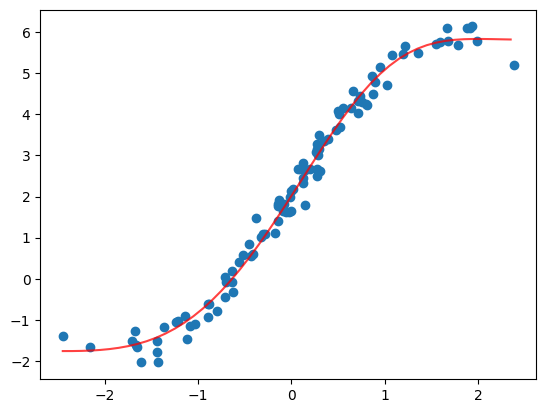

In [32]:
config = configs.TrainingConfig(
    optimizer=optimizers.OptimizerConfig(
        optimizer=optimizers.Optimizer.ADAM, learning_rate=1e-1
    ),
    num_train_steps=100,
)

# model = models.Linear(features=1, use_bias=True)
model = models.MLP(num_hidden=50, num_outputs=d, use_bias=True)

params = model.init(key, jnp.ones((1, d)))
print(jax.tree_util.tree_map(jnp.shape, params))

optimizer = config.optimizer.make()
opt_state = optimizer.init(params)

squared_error = lambda y, predictions: jnp.mean(jnp.square(y - predictions))
squared_error_vmap = jax.vmap(squared_error, in_axes=(0, 0), out_axes=0)
loss_fn = lambda params, x, y: jnp.mean(squared_error_vmap(y, model.apply(params, x)))
grad_fn = jax.value_and_grad(loss_fn)


for idx in range(config.num_train_steps):
    loss, gradients = grad_fn(params, x, y)
    print(f"Step {idx}: loss = {loss}")
    # params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, gradients)
    updates, opt_state = optimizer.update(gradients, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(x, y, "o")
plt.plot(
    xs,
    model.apply(params, xs).reshape(-1),
    "r",
    alpha=0.25 + idx / config.num_train_steps / 2,
)

In [29]:
tokenizer = tokenizers.TokenizerConfig(model="gpt2").make()
print(tokenizer.encode("Hello, world!"))

[15496, 11, 995, 0]
